# SCDAA Coursewrok
## Tianying Zhu, Ruize Wang
## Github Link: https://github.com/truedmg/Tianying-Ruize


# EX1

## EX1.1

In [9]:
import numpy as np
import torch
import scipy
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.integrate import solve_ivp
import random

class LQR_Riccati_ODE:
    def __init__(self, H, M, C, D, r, R, Sig):
        self.H = torch.tensor(H, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
        self.C = torch.tensor(C, dtype=torch.float32)
        self.D = torch.tensor(D, dtype=torch.float32)
        self.R = torch.tensor(R, dtype=torch.float32)
        self.r = torch.tensor(r) # start time and time rige
        self.Sig = torch.tensor(Sig, dtype = torch.float32)
        
    
    def solve_Riccati_ODE(self, r):
        n = self.H.shape[0]
        def f(r, Q):
            Q = torch.zeros(n, n)
            dQdr = 2 * (self.H.T @ Q) - Q @ self.M @ torch.inverse(self.D) @ self.M @ Q + self.C
            return dQdr.view(-1)
        
        sol = scipy.integrate.solve_ivp(f, t_span=[r[0],r[-1]], y0 = self.R, t_eval= r)
        sol.y = np.array(sol.y).T
        x = sol.y
        sol1 = np.flip(x,0)
        sol1 = torch.tensor(sol1.copy())

        sol2 = torch.empty(len(sol1),2,2)
        for i in range(len(sol1)):
            sol2[i]= sol1[i].view(2,2)
        return sol2
       
    
     
        
    def value_function(self, j, x):
        r = self.r
        Sig = self.Sig
        n_batch = x.shape[0] # the batch size
        V = torch.zeros(n_batch, 1) # create the tensor with scalar value 0 with size batch size times 1
        sol2 = self.solve_Riccati_ODE(r).type(torch.FloatTensor)
        x = x.type(torch.FloatTensor)
        
        def simp_integral(j):
            y = []
            for i in range(j,len(sol2)):
                y.append((Sig @ Sig.T @ sol2[i].view(2,2)).trace())
            return scipy.integrate.simps(y, r[j:])
      
        sol21 = sol2[j]
        sol21 =torch.unsqueeze(sol21,0)

        e = torch.empty(n_batch,2,2)
        e[:] =sol21

        x_T = torch.transpose(x,1,2)
        V = torch.bmm(torch.bmm(x,e),x_T)
        V = torch.add(V,simp_integral(j))
        
        return V
    


    def Markov_control_function(self, j, x):
        n_batch = x.shape[0]
        u = torch.zeros(n_batch, 2)
        r = self.r
        sol2 = self.solve_Riccati_ODE(r).type(torch.FloatTensor)
        
        D = torch.unsqueeze(self.D,0) # 2x2x1
        D = torch.transpose(D,1,2)
        
        M = self.M.T
        M = torch.unsqueeze(M,0) #2,2,1
        
        sol2 = sol2[j]
        sol2 =torch.unsqueeze(sol2,0)
        
        x = torch.transpose(x,1,2)

        e = torch.empty(n_batch,2,2)
        k1 = torch.bmm(torch.bmm(-D,M),sol2)
        e[:] = k1
        k = torch.bmm(e, x.type(torch.FloatTensor))
        return k


In [10]:
random.seed(0)
H = np.array([  [1,  0],[  0, 1]])
D = np.array([[0.1,   0],[  0, 0.1]])
C = np.array([[0.1, 0],  [0, 0.1]])
M = np.array([[1,   0],[  0, 1]])
R = np.array([1,0,0,1])
N = 100
T = 1
t = 0
r = np.linspace(0,T,N+1)
Sig= np.array([[0.05],[0.05]])


a = torch.tensor([[(1,0)],[(0,1)]])
LE= LQR_Riccati_ODE(H, M, C, D, r,R, Sig)

sol= LE.solve_Riccati_ODE(r) # 5000 2 2  sample size in one batch

c = LE.value_function(0, a) #n_batch 1 1 
d = LE.Markov_control_function(0,a)# n_batch 1 1

## EX1.2

In [11]:

def dx_(N,T,k,x):
    tao = T/N
    n_batch= x.shape[0]
    time_step = [k]
    ind = k
    for i in range(k,N):
        ind+=1
        time_step.append(ind*tao)
    flag = len(time_step)
    sol = torch.zeros(flag,n_batch,1,2)

    sol[0,:] =x[0] #empty case with intial value for now 

    H = LE.H
    H = torch.unsqueeze(H,0)
    H1 = torch.empty(n_batch,2,2)
    H1[:] = H
  
    M = LE.M
    M = torch.unsqueeze(M,0)
    M1 = torch.empty(n_batch,2,2)
    M1[:] = M
    M1_T = torch.transpose(M1,1,2)

    D = LE.D
    D = torch.unsqueeze(D,0)
    D1 = torch.empty(n_batch,2,2)
    D1[:] = D
  
    sol = torch.transpose(sol,2,3)

    sig = LE.Sig
    sig1= torch.zeros(n_batch,2,1)
    sig1[:] =sig
    
    for i in range(1,flag):
        dW = np.sqrt(tao) * np.random.randn(n_batch,1,1)
        dW = torch.tensor(dW)
        pre = sol[i-1]
        pre = torch.transpose(pre,1,2)

        alpha = LE.Markov_control_function(k+i-1,pre)
        sol[i] = sol[i-1] + tao*(torch.bmm(H1,sol[i-1])+ torch.bmm(M1,alpha))
        
        bron = torch.bmm(sig1,(dW).type(torch.FloatTensor))
        sol[i] = torch.add(sol[i],bron)
        
    sol = torch.transpose(sol,2,3)
    return sol



In [12]:
def perform(N,T,k,x,r):
    n_batch = x.shape[0]
    sig = LE.Sig
    sol = dx_(N,T,k,x)
    
    C = LE.C
    C = torch.unsqueeze(C,0)
    C1 = torch.empty(n_batch,2,2)
    C1[:] = C

    D = LE.D
    D = torch.unsqueeze(D,0)
    D1 = torch.empty(n_batch,2,2)
    D1[:] = D

    R = LE.R.view(2,2)
    R = torch.unsqueeze(R,0)
    R1 = torch.empty(n_batch,2,2)
    R1[:] = R

    def simp_integral(k):
        y =[]
        index = k
        for i in range(len(sol)):
            alpha = LE.Markov_control_function(index,sol[i])
            alpha_t = torch.transpose(alpha,1,2)
            A_k = torch.bmm(sol[i], C1)
            B_k = torch.bmm(A_k ,torch.transpose(sol[i],1,2))
      
            C_k = torch.bmm(alpha_t,D1)
            D_k = torch.bmm(C_k,alpha)
            add = torch.add(B_k,D_k)
            index +=1
            y.append(add)
        
        return scipy.integrate.simps(y, r[k:])

    J = torch.add(simp_integral(k),torch.bmm(torch.bmm(sol[-1],R1),torch.transpose(sol[-1],1,2)))
    return J


In [13]:
def sim_1(a,N,T,x,r):
    n_batch = x.shape[0]
    k = np.arange(0,N,a)
    mse = []
    for j in k:
        V = LE.value_function(j, x)
        V_pre = perform(N,r[-1],j,x,r)
        err = torch.sub(V_pre,V)
        err = torch.mean(err)
        err = err.item()
        mse.append(err)
    mse = np.mean(mse)
    return mse

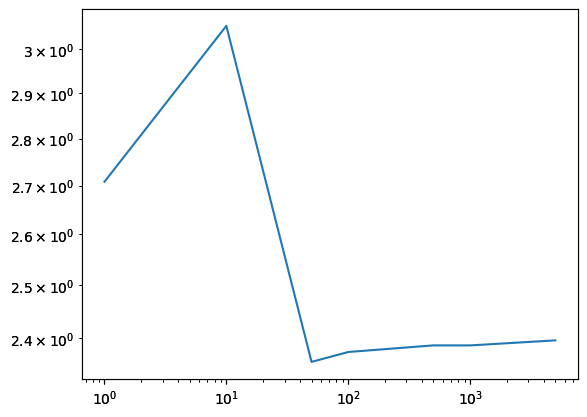

In [363]:
error =[]
timestep = [1,10,50,100,500,1000,5000]


at = torch.unsqueeze(a[0],0)
h_t = torch.zeros(10000,1,2)
h_t[:] = at



N1 = 1
r1 = np.linspace(0,T,N1+1)
LE = LQR_Riccati_ODE(H, M, C, D, r1,R, Sig)
error.append(sim_1(1,N1,T,h_t,r1))

N2 = 10
r2 = np.linspace(0,T,N2+1)
LE = LQR_Riccati_ODE(H, M, C, D, r2,R, Sig)
error.append(sim_1(5,N2,T,h_t,r2))

N6 = 50
r6 = np.linspace(0,T,N6+1)
LE = LQR_Riccati_ODE(H, M, C, D, r6,R, Sig)
error.append(sim_1(10,N6,T,h_t,r6))

N7 = 100
r7 = np.linspace(0,T,N7+1)
LE = LQR_Riccati_ODE(H, M, C, D, r7,R, Sig)
error.append(sim_1(20,N7,T,h_t,r7))

N3 = 500
r3 = np.linspace(0,T,N3+1)
LE = LQR_Riccati_ODE(H, M, C, D, r3,R, Sig)
error.append(sim_1(100,N3,T,h_t,r3))

N4 = 1000
r4 = np.linspace(0,T,N4+1)
LE = LQR_Riccati_ODE(H, M, C, D, r4,R, Sig)
error.append(sim_1(200,N4,T,h_t,r4))


N6 = 5000
r6 = np.linspace(0,T,N6+1)
LE = LQR_Riccati_ODE(H, M, C, D, r6,R, Sig)
error.append(sim_1(1000,N6,T,h_t,r6))


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_yscale('log')
ax.set_xscale('log')
ax.scatter(timestep, error)
ax = fig.add_subplot(1, 1, 1)
ax.loglog(timestep, error)


/usr/local/lib/python3.9/dist-packages/scipy/integrate/_quadrature.py:612: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  y = np.asarray(y)
/usr/local/lib/python3.9/dist-packages/scipy/integrate/_quadrature.py:612: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.asarray(y)


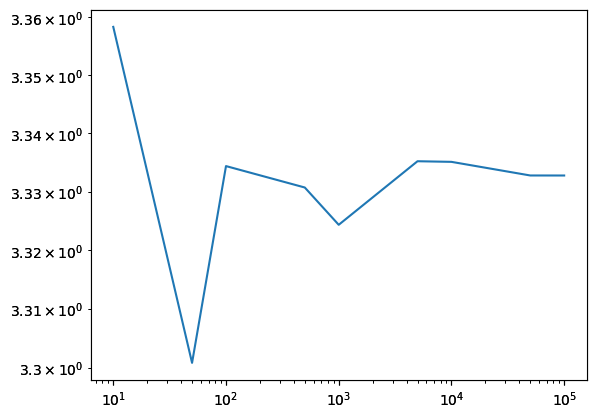

In [8]:
import matplotlib.pyplot as plt
error = []
Ns= 5000
rs = np.linspace(0, T, Ns+1)
LE = LQR_Riccati_ODE(H, M, C, D, rs, R, Sig)
'''
for i in sample:
    x = torch.empty(i,1,2)
    N = 5000
    r = np.linspace(0, T, N)
    error.append(sim(N,T,i,x))
'''

sample = [10,50,100,500,1000,5000, 10000,50000,100000]
a1 = torch.unsqueeze(a[0],0)

h_1 = torch.zeros(10,1,2)
h_1[:] = a1
error.append(sim_1(2500,Ns,T,h_1,rs))


h_2 = torch.zeros(50,1,2)
h_2[:] = a1
error.append(sim_1(2500,Ns,T,h_2,rs))


h_3 = torch.zeros(100,1,2)
h_3[:] = a1
error.append(sim_1(2500,Ns,T,h_3,rs))

h_4 = torch.zeros(500,1,2)
h_4[:] = a1
error.append(sim_1(2500,Ns,T,h_4,rs))

h_5 = torch.zeros(1000,1,2)
h_5[:] = a1
error.append(sim_1(2500,Ns,T,h_5,rs))

h_6 = torch.zeros(5000,1,2)
h_6[:] = a1
error.append(sim_1(2500,Ns,T,h_6,rs))

h_7 = torch.zeros(10000,1,2)
h_7[:] = a1
error.append(sim_1(2500,Ns,T,h_7,rs))

h_8 = torch.zeros(50000,1,2)
h_8[:] = a1
error.append(sim_1(2500,Ns,T,h_8,rs))

h_9 = torch.zeros(100000,1,2)
h_9[:] = a1
error.append(sim_1(2500,Ns,T,h_9,rs))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_yscale('log')
ax.set_xscale('log')
ax.scatter(sample, error)
ax = fig.add_subplot(1, 1, 1)
ax.loglog(sample, error)

### Exercise 1
For this task, a class named 'LQR_Riccati_ODE' is defined as above. This class initializes the object's attributes which are all defined as torch tensor :
* H, $2 \times 2$ matrix
* M, $2 \times 2$ matrix
* C, a $2 \times 2$ matrix and greater than zero
* D, a $2 \times 2$ matrix and greater than zero 
* R,  a $2 \times 2$ matrix and greater than zero 
* r,  time grid (np. linspace is called)
* Sigma, a $2\times1$ matrix

In this class, we defined 3 functions:  
* 'solve_Riccati_ODE' is used to solve the associated Ricatti ODE on a time grid which is the input, the initialized r. 

* 'value_function',  input is a time point and a batch size X 1 X 2;gives  a batch size X 1 represents the value v(t,x)

* 'Markov_control_function', input is a batch size X 1 X 2 and a time point; gives a batch size X 2 Markov control function for corresponding t, x in the batch.
#### Implementation of 'solve_Riccati_ODE(self,r)' and test
The task is to solve the Riccati_ODE, $$ S'(r) = -2H^TS(r)+S_tMD^{-1}MS(r) - C {and}  S(T) = R$$. Known that the given parameters are 2 dimensional matrix, the function 'scipy.integrate.solve_ivp' is called to solve a dimentional matrix integral problem. We only known the termial value, $S(T) = R$, thus let $Q(t) = S(T-t) $ then $Q(0) = S(T) = R$,$Q'(t) = -S'(T-t)$ and we just need to solve: $$Q'(t) = 2H^TQ(t)-Q(t)MD^{-1}MQ(t) +C {and} Q(0) = R$$. In order to test this called function can properly work, we set the parameter M,D and C to be the identity matrix and time grid is from 0 to 1 with a time interval 0.2. Thus, there should be 6 output and these outputs have also be checked after we calculating the discrete time dynamics by hand. And the outputs are the given solution at each time point. Then $S(t)$ is gained by flipping the solutions of Q with a minus sign.

#### Implementation of 'value_function(self,j,x)'
The aim for this task is to look for the value function at each time point by given a parameter $x^T$ which is a $1 × 2$ matrix. The value function is given below : $$v(t,x) = x^TS(t)x + ∫^T_ttrσσ^TSr)dr$$. 'Scipy.integrate.simp' is called to solve the integral part. After invoking the function 'solve_riccatti_ode', we iterate from time point t to the final time T and obtain the trace of the solution at each time point. Then, we compute an integral using these traces. To handle the input tensors which have a shape of batch size $× 1 × 2$, we utilize the 'torch.bmm' function to optimize our algorithm.

#### Impelmentation for 'Markov_control_function(self,j,x)'
It is used to solve markov control $α$ at each time point as well : $$α(t,x) = -DM^TS(t)x$$. The implementation is just shown in the code, basically same logic as the one for 'value_function.

#### Implementation of 'dx_(N,T,k,x)' and 'perform(N,T,k,x,r)'
NThe input parameter N corresponds to the total number of time steps, while T represents the time range of the simulation. The parameter k specifies the time point at which the simulation starts, and the tensor $x^T$ has a shape of batch size $× 1 × 2'.

In this problem, we adopt the Explicit method described in the notes to calculate the value of X at each time step, starting from the time point k. To accomplish this, we utilize a for loop that invokes the markov_control_function to compute the dynamics of X.

Subsequently, we develop a function to calculate the objective function, which is defined as follows:$$J^α(t,x) = ∫^T_t(X^T_sCX_s +α^TDα_s)ds + X^T_TRX_T$$. This function computes the integral of the term $X^T_sCX_s + α^TDα_s$ from time t to T, and adds the term $X^T_TRX_T$ to it. The parameter α represents a control parameter that we want to optimize.

### Overall Result

The first two plots in above outputs are followd the coursework requirement. The first one is varying the number of time-step with a fixed number of samples($10^4$)and the second one is varying number of samples with a fixed the time step (5000)

To apply monte carlo, we use the function sim_1(a,N,T,x,r). In this function, we use N(time steps) to generates more time point t (start time) to calculate the difference(we use mse) between predicted value function and value function from Ex1.1. Then, we use the 'for loop' to calculate the mean of mse at each start of time. Since we have numbers of batches, we use mean() function to cancel the impact given by brownian motion as the monte-carlo theory applied. And we also have use several many random time point(one fifth of the total number of timesteps) for each time step and look for the mean square error in order to make our results more convinceable. From the output of error against number of time step, it is clearly that there is a deep decreasing in error as time step inceasing. However, the plot does not seem to be converging with a small error range (from 2 to 1).I think this might be we are not actually applying monte-carlo theory properly, or the number of samples are not large enough to fully cancel the negative impact brought by the brownian motion. Even though we tried to use as less loos as we could(3 loos in total), the running time of our laptops still quite long for very large sample (approximately 4 hours for 100000 samples and the kernel died in the last min of 4 hours). The second plot is varying the number of samples with a fixed number of time step (5000). We applied the same method as used in the first plot. Alough the plot does not seem to be converging, it shows a decreasing error against increasing number of samples, which approximates around to 3.

## EX2 Supervised learning, checking the NNs are good enough
### Ex 2.1



In [14]:
import torch
import torch.nn as nn
import numpy as np
import tqdm

# from lib.options import BaseOption

class DGM_Layer(nn.Module):
    
    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(DGM_Layer, self).__init__()
        
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))
            

        self.gate_Z = self.layer(dim_x+dim_S, dim_S)
        self.gate_G = self.layer(dim_x+dim_S, dim_S)
        self.gate_R = self.layer(dim_x+dim_S, dim_S)
        self.gate_H = self.layer(dim_x+dim_S, dim_S)
            
    def layer(self, nIn, nOut):
        l = nn.Sequential(nn.Linear(nIn, nOut), self.activation)
        return l
    
    def forward(self, x, S):
        x_S = torch.cat([x,S],1)
        Z = self.gate_Z(x_S)
        G = self.gate_G(x_S)
        R = self.gate_R(x_S)
        
        input_gate_H = torch.cat([x, S*R],1)
        H = self.gate_H(input_gate_H)
        
        output = ((1-G))*H + Z*S
        return output


class Net_DGM(nn.Module):

    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(Net_DGM, self).__init__()

        self.dim = dim_x
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))

        self.input_layer = nn.Sequential(nn.Linear(dim_x+1, dim_S), self.activation)

        self.DGM1 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        self.DGM2 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        self.DGM3 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)

        self.output_layer = nn.Linear(dim_S, 1)

    def forward(self,t,x):
        tx = torch.cat([t,x], 1)
        S1 = self.input_layer(tx)
        S2 = self.DGM1(tx,S1)
        S3 = self.DGM2(tx,S2)
        S4 = self.DGM3(tx,S3)
        output = self.output_layer(S4)
        return output

<ipython-input-15-e9ddce696359>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).float()
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


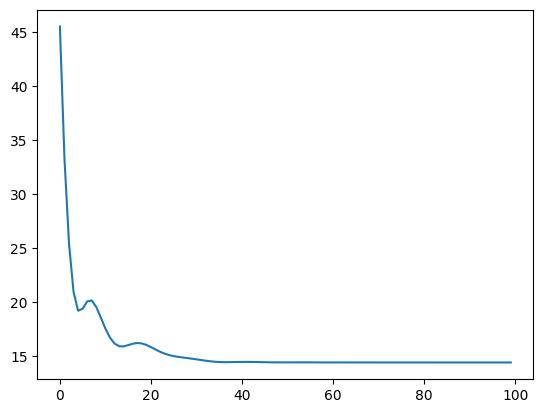

In [15]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
# Generate some training data
x_train = np.random.uniform(-3, 3, size=(100, 2))
t_train = np.random.randint( 100, size=(100, 1))

x_train = torch.tensor(x_train)
y_train = []
for i in range(len(x_train)):
  x_train_0 = torch.unsqueeze(x_train,1)
  y_train.append(LE.value_function(int(t_train[i]), torch.unsqueeze(x_train_0[i],1)))
  

# Convert the data to PyTorch tensors
x_train = torch.tensor(x_train).float()
t_train = torch.tensor(t_train).float()
y_train = torch.tensor(y_train).float()

# Define the DGM network architecture
net = Net_DGM(dim_x=2, dim_S=100, activation='Tanh')

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

loss1 = []
# Train the network
for epoch in range(100):
    optimizer.zero_grad()
    y_pred = net(t_train, x_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    loss1.append( loss.item())

plt.plot(range(100),loss1)


In [16]:
import torch
import torch.nn as nn
from collections import namedtuple
from typing import Tuple

class FFN(nn.Module):

    def __init__(self, sizes, activation=nn.ReLU, output_activation=nn.Identity, batch_norm=False):
        super().__init__()
        
        layers = [nn.BatchNorm1d(sizes[0]),] if batch_norm else []
        for j in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[j], sizes[j+1]))
            if batch_norm:
                layers.append(nn.BatchNorm1d(sizes[j+1], affine=True))
            if j<(len(sizes)-2):
                layers.append(activation())
            else:
                layers.append(output_activation())

        self.net = nn.Sequential(*layers)

    def freeze(self):
        for p in self.parameters():
            p.requires_grad=False

    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad=True

    def forward(self, x):
        return self.net(x)


class FFN_net_per_timestep(nn.Module):

    def __init__(self, sizes, ts: torch.Tensor, activation=nn.ReLU, output_activation=nn.Identity):
        super().__init__()
        self.net = nn.ModuleList([FFN(sizes, activation, output_activation, batch_norm=False) for t in ts])

    def forward(self, x, idt = None):

        if x.dim() == 3: # x is of shape (batch_size, L, d)
            Y = []
            for i in range(x.shape[1]):
                Y.append(self.net[i](x[:,i,:]))
            Y = torch.stack(Y, 1)
        elif x.dim() == 2 and idt is not None:
            Y = self.net[idt](x)
        else:
            raise ValueError('idt needs to be passed')
        return Y


class RNN(nn.Module):

    def __init__(self, rnn_in, rnn_hidden, ffn_sizes, activation=nn.ReLU, output_activation=nn.Identity):
        super().__init__()
        self.rnn = nn.LSTM(input_size=rnn_in, hidden_size=rnn_hidden,
                num_layers=1,
                batch_first=True)
        layers = []
        for j in range(len(ffn_sizes)-1):
            layers.append(nn.Linear(ffn_sizes[j], ffn_sizes[j+1]))
            if j<(len(ffn_sizes)-2):
                layers.append(activation())
            else:
                layers.append(output_activation())

        self.ffn = nn.Sequential(*layers)

    def freeze(self):
        for p in self.parameters():
            p.requires_grad=False

    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad=True
            
    def forward(self, x):
        """Forward method 
        
        Parameters
        ----------
        x : torch.Tensor
            Sequential input. Tensor of size (N,L,d) where N is batch size, L is lenght of the sequence, and d is dimension of the path
        Returns
        -------
        output : torch.Tensor
            Sequential output. Tensor of size (N, L, d_out) containing the output from the last layer of the RNN for each timestep
        """
        output_RNN, _ = self.rnn(x)
        output = self.ffn(output_RNN)
        return output

<ipython-input-17-0c35c370b515>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_2 = torch.tensor(x_train_2).float()


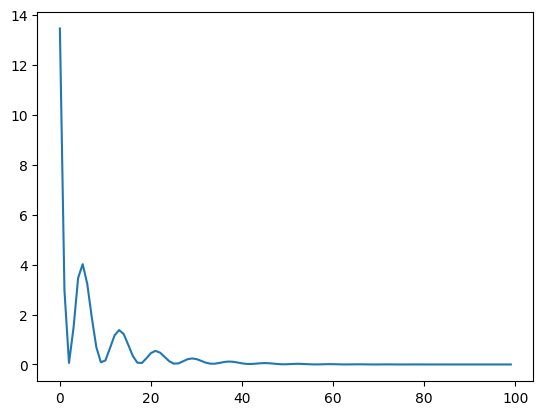

In [17]:
import torch
import torch.nn as nn
import numpy as np

# Generate some training data
x_train_2 = np.random.uniform(-3, 3, size=(100, 2))
t_train_2 = np.random.randint(100, size=(100, 1)) #this is the nth time point i want to input into the markov control

x_train_2 = torch.tensor(x_train_2)
x_train_2_0= torch.unsqueeze(x_train_2[0],0)
x_train_2_1 = torch.unsqueeze(x_train_2_0,0)
y_train_2 = np.zeros((len(t_train_2),2))


for i in range(len(x_train)):
  x_train_2_0 = torch.unsqueeze(x_train_2,1)
  x_2_k = LE.Markov_control_function(int(t_train_2[i]), torch.unsqueeze(x_train_2_0[i],1))

  y_train_2[i,:]=torch.squeeze(x_2_k,2)

# Convert the data to PyTorch tensors
x_train_2 = torch.tensor(x_train_2).float()
t_train_2 = torch.tensor(t_train_2).float()
y_train_2 = torch.tensor(y_train_2).float()




# Define the FNN network architecture
net2 = FFN([3,100,100,2], activation=nn.ReLU, output_activation=nn.Identity, batch_norm=False)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net2.parameters(), lr=0.001)
catxt = torch.cat([t_train_2,x_train_2],1)

loss1 = []
# Train the network
for epoch in range(100):
    optimizer.zero_grad()
    y_pred = net2(catxt)
    loss = criterion(y_pred, y_train_2)
    loss.backward()
    optimizer.step()
    loss1.append( loss.item())
    
plt.plot(range(100),loss1)


## 2 Supervised learning, checking the NNs are good enough
### Ex 2.1

For task 2.1, the class "Net_DGM" is used. This class builds a neural network. 


*   function '__ init __': this function initializes the setting of the neural network. It requires to set the dimension of the input x, the size of hidden layer and the activiation method.
*   function 'forward': this function generates the output. It is the process to make the input pass through the neural network.

In this task, the supervised learning function is the value function defined in Exercise 1.1. The first thing is defining the DGM network. The input $x^T$ is the $1 \times 2$ tensor and the required hidden layer size is 100. Thus, the DGM network is initialized with dim_x=2 and dim_S=100.

The next step is generating some training data for the network. "x_train" is created by sampling 100 data points from a uniform distribution between -3 and 3. Since $x^T$ is the $batch\_ size \times 1\times2$ tensor. Thus, the x_train is created with the size $100\times2$. Also, the random integer values between 0 to 99 are generated and stored in "t_train". Then, the value function is calculated for each (x_train, t_train) pair using the value function defined in Ex 1.1., and the results are stored in "y_train". 

Afterward, the training data is converted to PyTorch tensors and the Mean Squared Error (MSE) loss function is defined using the nn.MSELoss() method. Also, the Adam optimizer is defined with a learning rate of 0.001 and the network parameters are updated using optimizer.step() method.

Finally, the network is trained for epoches in range 0 to 100 by looping through the training data, zeroing the optimizer gradients using optimizer.The epoch means the number of batchs used to calculate the loss each time. Then, predicting the output using the net(t_train, x_train) method, calculating the loss between predicted output and true output using the criterion method, backpropagating the loss using loss.backward() method, and updating the parameters using optimizer.step() method. The loss values for each epoch are stored in the loss1 list and then plotted using plt.plot() method.


### Ex 2.2
For task 2.2, the class "FFN" is used. This class builds a neural network. 


*   function '__ init __': this function initialized the setting of the network. The 'size' needs to input a list of integers representing the sizes of the input, hidden, and output layers of the network. The 'activation' sets the activation method used for all hidden layers of the network. The 'output_activation' sets the activation method used for the output layer of the network. And requires to set whether the batch size is normalized or not.
*   function 'freeze': freezing the parameters so that their values cannot be updated during training.


*   function 'unfreeze': the values of the parameters can be updated during training.
*   function 'forward': the process to make the input pass through the neural network.
In this task, the supervised learning function is the markov control function defined in Exercise 1.1. The markov control function returns the optimal control values with dimension 2 for each column of $x^T$. Thus, the size of input layer is 3, t and $x^T$. There are 2 hidden layers with size 100. The output is the 2 optimal control values. Thus, the FFN network is initialized with size = [3,100,100,2]. 

For generating the training data, first generates two sets of training data, 'x_train_2' and 't_train_2', where 'x_train_2' is a 2-dimensional tensor of random values between -3 and 3, and 't_train_2' is a 1-dimensional tensor of random integers between 0 and 99. These tensors are used to generate the true output, 'y_train_2'. Apply a Markov control function to each input vector in x_train_2 at the corresponding time point in t_train_2. Then, the training data is converted to PyTorch tensors.

A mean squared error loss function is defined using nn.MSELoss(). the Adam optimizer is defined with a learning rate of 0.001 and the network parameters are updated using optimizer.step() method.

The FNN is trained for epoches in range 0 to 100 using a loop that iterates over the training data. In each epoch, the optimizer is zeroed, the predicted output y_pred is computed by applying the FNN to the concatenation of t_train_2 and x_train_2, and the MSE loss between y_pred and y_train_2 is computed. The loss is then backpropagated through the network and the optimizer is used to update the network parameters. The loss value for each epoch is saved in the loss1 list. 

### OutPuts analysis

####  Plot for Value functions
The first plot in exercise 2 is the plot for the value functions. The x-axis is the number of epoches and the y-axis is the loss  between the predicted value and the actual value. From the plot, we could see that the after training the whole dataset 20 times(20 epoches), the loss get fixed and approximately around 15. It means that as the model is trained, it updates its parameters in order to decrease the loss. The hope is that, over time, the model will converge to a set of parameters that yield the smallest possible loss on the training data. Once this is achieved, the model can be used to make predictions on new, unseen data with a good level of accuracy.

#### Plot for Markov Control 
The second plot in exercise 2 stands for the markov control and it has the same method as the above one. This time, after about 20 epoches, the loss function just converge to zero which means it makes a good prediction.


## 3 Deep Galerkin approximation for a linear PDE

In [18]:
import torch 
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from scipy.stats import norm
from matplotlib import cm

In [19]:
class Net(nn.Module):
    # NL: the number of hidden layers
    # NN: the number of vertices in each layer
    def __init__(self, NL, NN):
        super(Net, self).__init__()

        self.input_layer = nn.Linear(3, NN)

        self.hidden_layers = nn.ModuleList([nn.Linear(NN, NN) for i in range(NL)])

        self.output_layer = nn.Linear(NN, 1)

    def forward(self, x):
        o = self.act(self.input_layer(x))

        for i, li in enumerate(self.hidden_layers):
            o = self.act(li(o))
        
        out = self.output_layer(o)
        
        return out

    def act(self, x):
        return x * torch.sigmoid(x)

In [20]:


class Heat():
    
    def __init__(self, net, t_train, x_train,alpha1):
        self.net = net
        
        self.alpha1 = alpha1
        self.t_train = t_train
        self.x_train = x_train

    def sample(self,size):
        t_train = self.t_train
        x_train = self.x_train
        
        x = torch.cat((t_train, x_train), dim=1)
        
        x_initial = torch.cat((torch.zeros(1, 1), torch.rand([1, 2]) ), dim=1)
        return x, x_initial 
      
    def loss_func(self, size):
        
        x, x_initial = self.sample(size = size)
        
        x = Variable(x, requires_grad=True)
        
        alpha1 = self.alpha1
        
        
        x_f  = torch.zeros([size,2])
        x_f[:,0] = x[:,1]
        x_f[:,1] = x[:,2]
        x_f = torch.unsqueeze(x_f,1)
        
        d = torch.autograd.grad(self.net(x), x, grad_outputs=torch.ones_like(self.net(x)), create_graph=True)
        dt = d[0][:, 0].reshape(-1, 1)
        dt = torch.unsqueeze(dt,1)  # transform the vector into a column vector
        #dx1,dx2 stands for the the 1st and 2nd of dx
        dx1 = d[0][:, 1].reshape(-1, 1)
        dx2 = d[0][:, 2].reshape(-1, 1)
        
        dx_cat = torch.cat((dx1,dx2),1)
        dx_cat = torch.unsqueeze(dx_cat,1)
        
        
        dxx1 = torch.autograd.grad(dx1, x, grad_outputs=torch.ones_like(dx1), create_graph=True)[0][:, 1].reshape(-1, 1)
        dxx2 = torch.autograd.grad(dx2, x, grad_outputs=torch.ones_like(dx2), create_graph=True)[0][:, 2].reshape(-1, 1)
        dx1x2 = torch.autograd.grad(dx1, x, grad_outputs=torch.ones_like(dx2), create_graph=True)[0][:, 2].reshape(-1, 1)
        dx2x1 = torch.autograd.grad(dx2, x, grad_outputs=torch.ones_like(dx2), create_graph=True)[0][:, 1].reshape(-1, 1)
        
        dxx_cat = torch.cat((dxx1,dx1x2,dx2x1,dxx2),1)
        dxx_cat = dxx_cat.view(size,2,2)
        
        Sig= LE.Sig
        Sig= torch.unsqueeze(Sig,0)
        Sig1 = torch.empty(size,2,1)
        Sig1[:] = Sig

        C = LE.C
        C = torch.unsqueeze(C,0)
        C1 = torch.empty(size,2,2)
        C1[:] = C

        H = LE.H
        H = torch.unsqueeze(H,0)
        H1 = torch.empty(size,2,2)
        H1[:] = H

        D = LE.D
        D = torch.unsqueeze(D,0)
        D1 = torch.empty(size,2,2)
        D1[:] = D

        M= LE.M
        M = torch.unsqueeze(M,0)
        M1 = torch.empty(size,2,2)
        M1[:] = M
        
        R = LE.R
        R = R.view(2,2)
        R = torch.unsqueeze(R,0)
        R1 = torch.empty(size,2,2)
        R1[:] = R

        x0 = torch.tensor([[1,2]])
        x0 = torch.unsqueeze(x0,0)
        x0 = torch.tensor(x0, dtype=torch.float32)
        x_i_1 = torch.bmm(x0,torch.bmm(R,torch.transpose(x0,1,2)))
        x_i_1 = torch.tensor(x_i_1, dtype=torch.float32)
        x_i_2 = torch.bmm(x0,torch.bmm(R,torch.transpose(x0,1,2)))
        x_i_2 = torch.tensor(x_i_2, dtype=torch.float32)
        x_initial_1 = torch.cat((torch.zeros(1, 1),x_i_1.squeeze(1),x_i_2.squeeze(1)),1)
        
      
        f = torch.add(dt, 0.5*(torch.bmm(torch.bmm(Sig1, torch.transpose(Sig1,1,2)),dxx_cat).diagonal(offset=0, dim1=-1, dim2=-2).sum(-1)))+ torch.bmm(dx_cat,torch.bmm(H1,torch.transpose(x_f,1,2)))+ torch.bmm(dx_cat,torch.bmm( M1 , alpha1))+ torch.bmm(torch.bmm( x_f,C1) ,torch.transpose(x_f,1,2)) + torch.bmm(torch.bmm(alpha1.transpose(1,2) ,D1 ),alpha1)
        
        diff_error = f.reshape(-1, 1)**2
        
        # initial condition
        init_error = (self.net(x_initial_1)) ** 2
        return torch.mean(diff_error + init_error ),diff_error 



In [21]:

class Train():
    def __init__(self, net, heateq, BATCH_SIZE):
        self.errors = []
        self.BATCH_SIZE = BATCH_SIZE
        self.net = net
        self.model = heateq
        self.value_exact = []
    def train(self, epoch, lr,BATCH_SIZE):
        optimizer = optim.Adam(self.net.parameters(), lr)
        avg_loss = 0
        for e in range(epoch):
            optimizer.zero_grad()
            loss,v_value_exa = self.model.loss_func(self.BATCH_SIZE)
            
            avg_loss = avg_loss + float(loss.item())
            loss.backward(retain_graph = True)
            optimizer.step()
            self.value_exact.append(v_value_exa.detach())
            
          
            if e % 50 == 49:
               loss = avg_loss/50
               print("Epoch {} - lr {} -  loss: {}".format(e, lr, loss))
               avg_loss = 0
              
               error = self.model.loss_func(size)[0]
               self.errors.append(error.detach())
               
        
    def get_errors(self):
        return self.errors
        
    def get_value(self):
        return self.value_exact

<ipython-input-20-35554798f24b>:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.float32)
<ipython-input-20-35554798f24b>:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_i_1 = torch.tensor(x_i_1, dtype=torch.float32)
<ipython-input-20-35554798f24b>:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_i_2 = torch.tensor(x_i_2, dtype=torch.float32)


Epoch 49 - lr 0.0001 -  loss: 0.0913883650302887
Epoch 99 - lr 0.0001 -  loss: 0.06561382971704006
Epoch 149 - lr 0.0001 -  loss: 0.050355175882577895
Epoch 199 - lr 0.0001 -  loss: 0.041337268501520155
Epoch 249 - lr 0.0001 -  loss: 0.034929653480649
Epoch 299 - lr 0.0001 -  loss: 0.02895429164171219
Epoch 349 - lr 0.0001 -  loss: 0.022982701659202576
Epoch 399 - lr 0.0001 -  loss: 0.01718612005934119
Epoch 449 - lr 0.0001 -  loss: 0.0119048535451293
Epoch 499 - lr 0.0001 -  loss: 0.0075338039360940455
Epoch 549 - lr 0.0001 -  loss: 0.004364525028504432
Epoch 599 - lr 0.0001 -  loss: 0.0024222659692168234
Epoch 649 - lr 0.0001 -  loss: 0.0014428844209760428
Epoch 699 - lr 0.0001 -  loss: 0.0010381650866474956
Epoch 749 - lr 0.0001 -  loss: 0.0008950497419573367
Epoch 799 - lr 0.0001 -  loss: 0.00084484729799442
Epoch 849 - lr 0.0001 -  loss: 0.000821357712848112
Epoch 899 - lr 0.0001 -  loss: 0.0008043523563537747
Epoch 949 - lr 0.0001 -  loss: 0.0007887570874299854
Epoch 999 - lr 0.0

Text(0.5, 1.0, 'Training Loss')

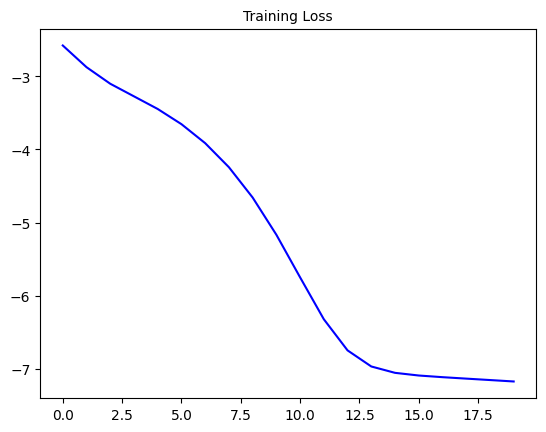

In [22]:
net = Net(NL=2, NN=20)
size = 100
BATCH_SIZE =100
x_train3 = torch.rand([size, 2])
t_train3 = torch.rand([size, 1])

alpha = torch.transpose(torch.tensor(np.array([[1,1]])),0,1)
alpha= torch.unsqueeze(alpha,0)
alpha1 = torch.empty(size,2,1)
alpha1[:] = alpha

heatequation = Heat(net, t_train3, x_train3, alpha1)

train = Train(net, heatequation, BATCH_SIZE)

train.train(epoch=1000, lr=0.0001,BATCH_SIZE = size)

torch.save(net, 'net_model.pkl')

errors = train.get_errors()

#plot errors
fig = plt.figure()
plt.plot(np.log(errors), '-b', label='Errors')
plt.title('Training Loss', fontsize=10)


In [23]:
heatequation_sim = Heat(net, t_train3, x_train3, alpha1)

train_sim = Train(net, heatequation_sim, BATCH_SIZE)

train_sim.train(epoch=1, lr=0.0001,BATCH_SIZE = 100)

torch.save(net, 'net_model.pkl')

value_eax = train_sim.get_value()

<ipython-input-20-35554798f24b>:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.float32)
<ipython-input-20-35554798f24b>:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_i_1 = torch.tensor(x_i_1, dtype=torch.float32)
<ipython-input-20-35554798f24b>:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_i_2 = torch.tensor(x_i_2, dtype=torch.float32)


In [24]:
def dx_2(N,T,k,x):  #fixed markov control (1,1)
    tao = T/N
    n_batch= x.shape[0]
    time_step = [k]
    ind = k
    for i in range(k,N):
        ind+=1
        time_step.append(ind*tao)
    flag = len(time_step)
    sol = torch.zeros(flag,n_batch,1,2)
  
    sol[0,:] =x[0] #empty case with intial value for now 

    H = LE.H
    H = torch.unsqueeze(H,0)
    H1 = torch.empty(n_batch,2,2)
    H1[:] = H
  
    M = LE.M
    M = torch.unsqueeze(M,0)
    M1 = torch.empty(n_batch,2,2)
    M1[:] = M
    M1_T = torch.transpose(M1,1,2)
   
    D = LE.D
    D = torch.unsqueeze(D,0)
    D1 = torch.empty(n_batch,2,2)
    D1[:] = D
  
    sol = torch.transpose(sol,2,3)
    sig = LE.Sig
    sig1= torch.zeros(n_batch,2,1)
    sig1[:] =sig
    
    
    alpha = torch.transpose(torch.tensor(np.array([[1,1]])),0,1)
    alpha= torch.unsqueeze(alpha,0)
    alpha1 = torch.empty(size,2,1)
    alpha1[:] = alpha

    for i in range(1,flag):
        dW = np.sqrt(tao) * np.random.randn(n_batch,1,1)
        dW = torch.tensor(dW)
        pre = sol[i-1]
        pre = torch.transpose(pre,1,2)
        sol[i] = sol[i-1] + tao*(torch.bmm(H1,sol[i-1])+ torch.bmm(M1,alpha1))
        bron = torch.bmm(sig1,(dW).type(torch.FloatTensor))
        sol[i] = torch.add(sol[i],bron)
        
    sol = torch.transpose(sol,2,3)
    return sol


<ipython-input-25-16d0f81d79f5>:50: UserWarning: An output with one or more elements was resized since it had shape [1, 10000, 1], which does not match the required output shape [10000, 1]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:26.)
  torch.cat(V, out=b)


Text(0.5, 1.0, 'Error against EX1.2')

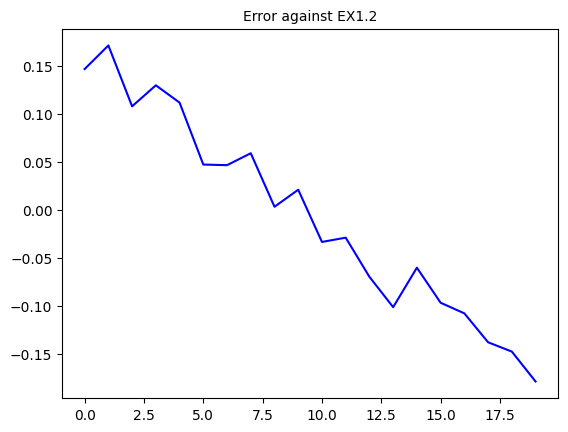

In [25]:
def perform2(N,T,k,x,r):
    n_batch = x.shape[0]
    sig = LE.Sig
    sol = dx_2(N,T,k,x)
    
    C = LE.C
    C = torch.unsqueeze(C,0)
    C1 = torch.empty(n_batch,2,2)
    C1[:] = C

    D = LE.D
    D = torch.unsqueeze(D,0)
    D1 = torch.empty(n_batch,2,2)
    D1[:] = D

    R = LE.R.view(2,2)
    R = torch.unsqueeze(R,0)
    R1 = torch.empty(n_batch,2,2)
    R1[:] = R
    
    alpha = torch.transpose(torch.tensor(np.array([[1,1]])),0,1)
    alpha= torch.unsqueeze(alpha,0)
    alpha1 = torch.empty(size,2,1)
    alpha1[:] = alpha

    def simp_integral(k):
        y =[]
        index = k
        for i in range(len(sol)):
            A_k = torch.bmm(sol[i], C1)
            B_k = torch.bmm(A_k ,torch.transpose(sol[i],1,2))
      
            C_k = torch.bmm(alpha1.transpose(1,2),D1)
            D_k = torch.bmm(C_k,alpha1)
            add = torch.add(B_k,D_k)
            index +=1
            y.append(add)
        return scipy.integrate.simps(y, r[k:])

    J = torch.add(simp_integral(k),torch.bmm(torch.bmm(sol[-1],R1),torch.transpose(sol[-1],1,2)))
    return J

def sim_2(a,N,T,x,r):
    n_batch = x.shape[0]
    k = list(range(20,40))
    mse = []
    V = value_eax
      
    b = torch.Tensor(1, 10000, 1)
    torch.cat(V, out=b)
    
    for j in k:
        V_pre = perform(N,r[-1],j,x,r)
        err = torch.sub(V_pre,b)
        err = torch.mean(err)
        err = err.item()
        mse.append(np.mean(err))
    return mse

error_fix_alpha= sim_2(20, 100,r[-1],x_train3,r)
fig = plt.figure()
plt.plot(np.log(error_fix_alpha), '-b', label='Errors')
plt.title('Error against EX1.2', fontsize=10)

## EX3 analysis
### Net Class
This code defines a neural network class called "Net" with a constructor that takes two parameters: NL, the number of hidden layers, and NN, the number of vertices in each layer. The __init__ method of this class initializes the input layer as a linear transformation with 3 inputs and NN outputs, and initializes the hidden layers as a list of NL linear transformations with NN inputs and NN outputs ,where NN represents the number of neurons. For the input, we give it three features, the timepoint, the first and second elements of a $1×2$ vector x. And the output is optimal value function.

The forward method defines the forward pass of the neural network. It takes an input tensor x and applies the input layer to it, followed by the hidden layers and an output layer that maps the output of the final hidden layer to a scalar output. The activation function used in the hidden layers is defined in the act method, which computes the element-wise product of the input tensor and the sigmoid function applied to the input tensor.

### Heat Class

We define a class called Heat, which takes in a neural network net, training data t_train and x_train, and a parameter alpha1, the fixed markov control $α =(1,1)^T$  as inputs. The __init__ function initializes these inputs as instance variables.

The sample method creates a training set of inputs x and initial conditions x_initial by concatenating the t_train and x_train tensors. x_initial is created by concatenating a tensor of zeros with a tensor of randomly generated values. The loss_func method calculates the loss function for the heat equation.

Inside loss_func, sample is called to generate x and x_initial. Then, x is defined as a Variable with requires_grad=True, which means that its gradients will be calculated during backpropagation.

The method then calculates the partial derivatives dt, dx1, and dx2 of net(x) with respect to t, x1, and x2, respectively, using torch.autograd.grad. These derivatives are used to calculate the second partial derivatives dxx1, dxx2, dx1x2, and dx2x1 and cat them togther as it follows the jacobian matrix. Thus, we can finally gain $∂_{xx}u$ by torch.cat these together and reshape them into \begin{pmatrix}
dx1x1 & dx1dx2 \\
dx2dx1 & dx2x2 
\end{pmatrix}

Several constants, including Sig, C, H, D, M, and R, are defined using the LE object. These constants are multiplied by various combinations of dxx_cat which is the $∂_{xx}$, dx_cat which is the $∂_x$, alpha1, and x_f using torch.bmm and torch.transpose to calculate the terms of the heat equation. Finally, the loss is returned as the sum of these terms.

### Train class
Defines a class 'Train' that provides a method to train a neural network using the Adam optimizer and the specified learning rate and batch size. The loss_func method of the heateq object is used to calculate the loss, and the errors are stored in a list. The train method prints the average loss after every 50 epochs and appends the errors to the errors list.

### Final output of the training loss 
We firstly initializes a neural network using the Net class with 2 input neurons (NL=2) and 20 hidden neurons (NN=20). It also creates two PyTorch tensors, x_train3 and t_train3, each of size (size, 2) and (size, 1) respectively, where size is set to 100.

The x_train3 tensor represents the input training data, where each row corresponds to a single input feature vector of length 2. The t_train3 tensor represents the target training data, where each row corresponds to a single scalar target value. In this case, the inputs and targets are randomly generated using the rand function in PyTorch.

After training, the network is saved to a pickle file called 'net_model.pkl'. The errors from the training process are retrieved using the get_errors method of the Train class, and a plot of the errors is generated.

And the training loss plot is shown above, we could see that the training loss is keep decreasing.It indicates that the model is getting better at predicting the correct output. This is a good sign as it suggests that the model is learning from the training data and becoming more accurate. 


### Final output for the error against Montecarlo
After replace alpha using fixed new alpha $[1,1]^T$, we decided to use a time point from the 20th to the 40th as our time interval and the time interval is 0.02. The plot is shown above.It is clearly the output is decreasing.










## 4 Policy iteration with DGM


In [26]:
class Net_1(nn.Module):
    def __init__(self, n_layer, n_hidden, dim):
        super(Net_1, self).__init__()
        self.dim = dim
        self.input_layer = nn.Linear(dim, n_hidden)
        self.hidden_layers = nn.ModuleList([nn.Linear(n_hidden, n_hidden) for i in range(n_layer)])
        self.output_layer = nn.Linear(n_hidden, 2)
        
    def forward(self, x):
        o = self.act(self.input_layer(x))

        for i, li in enumerate(self.hidden_layers):
            o = self.act(li(o))
        
        out = self.output_layer(o)
        
        return out

    def act(self, x):
        return x * torch.sigmoid(x)

class Heat_1():
    def __init__(self, net_v,net_a, t_train,x_train):
        self.net_v = net_v
        self.net_a = net_a
        self.alpha1 = alpha1
        self.t_train = t_train
        self.x_train = x_train

    def sample(self,size):
        t_train = self.t_train
        x_train = self.x_train
        
        x = torch.cat((t_train, x_train), dim=1)
        
        x_initial = torch.cat((torch.zeros(1, 1), torch.rand([1, 2]) ), dim=1)
        return x, x_initial


    def loss_func(self, size):
       
        x, x_initial = self.sample(size = size)
        
        x = Variable(x, requires_grad=True)
        self.alpha1 = self.net_a(x)
        alpha1 = torch.unsqueeze(self.alpha1, 1)
       
        x_f  = torch.zeros([size,2])
        x_f[:,0] = x[:,1]
        x_f[:,1] = x[:,2]
        x_f = torch.unsqueeze(x_f,1)

        d = torch.autograd.grad(self.net_v(x), x, grad_outputs=torch.ones_like(self.net_v(x)), create_graph=True)
        dt = d[0][:, 0].reshape(-1, 1)
        dt = torch.unsqueeze(dt,1)  # transform the vector into a column vector
        #dx1,dx2 stands for the the 1st and 2nd of dx
        dx1 = d[0][:, 1].reshape(-1, 1)
        dx2 = d[0][:, 2].reshape(-1, 1)
        
        dx_cat = torch.cat((dx1,dx2),1)
        dx_cat = torch.unsqueeze(dx_cat,1)
        
        
        dxx1 = torch.autograd.grad(dx1, x, grad_outputs=torch.ones_like(dx1), create_graph=True)[0][:, 1].reshape(-1, 1)
        dx1x2 = torch.autograd.grad(dx1, x, grad_outputs=torch.ones_like(dx2), create_graph=True)[0][:, 2].reshape(-1, 1)
        dx2x1 = torch.autograd.grad(dx2, x, grad_outputs=torch.ones_like(dx2), create_graph=True)[0][:, 1].reshape(-1, 1)
        dxx2 = torch.autograd.grad(dx2, x, grad_outputs=torch.ones_like(dx2), create_graph=True)[0][:, 2].reshape(-1, 1)
        
        dxx_cat = torch.cat((dxx1,dx1x2,dx2x1,dxx2),1)
        dxx_cat = dxx_cat.view(size,2,2)
        
       
        Sig= LE.Sig
        Sig= torch.unsqueeze(Sig,0)
        Sig1 = torch.empty(size,2,1)
        Sig1[:] = Sig

        C = LE.C
        C = torch.unsqueeze(C,0)
        C1 = torch.empty(size,2,2)
        C1[:] = C

        H = LE.H
        H = torch.unsqueeze(H,0)
        H1 = torch.empty(size,2,2)
        H1[:] = H

        D = LE.D
        D = torch.unsqueeze(D,0)
        D1 = torch.empty(size,2,2)
        D1[:] = D

        M= LE.M
        M = torch.unsqueeze(M,0)
        M1 = torch.empty(size,2,2)
        M1[:] = M
        
        R = LE.R
        R = R.view(2,2)
        R = torch.unsqueeze(R,0)
        R1 = torch.empty(size,2,2)
        R1[:] = R

        f = torch.bmm(dx_cat,torch.bmm(H1,x_f.transpose(1,2)))+torch.bmm(dx_cat,torch.bmm(M1,alpha1.transpose(1,2)))+torch.bmm(torch.bmm(x_f,C1),x_f.transpose(1,2))+torch.bmm(torch.bmm(alpha1,D1),alpha1.transpose(1,2))
        
        diff_error = f.reshape(-1, 1)**2
        
    
        return torch.mean(diff_error)

        

class Train_1():
    def __init__(self, net, heateq, BATCH_SIZE):
        self.errors = []
        self.BATCH_SIZE = BATCH_SIZE
        self.net = net
        self.model = heateq

    def train(self, epoch, lr):
        optimizer = torch.optim.Adam(self.net.parameters(), lr)
        avg_loss = 0
        for e in range(epoch):
            optimizer.zero_grad()
            loss = self.model.loss_func(self.BATCH_SIZE)
            avg_loss = avg_loss + float(loss.item())
            loss.backward(retain_graph = True)
            optimizer.step()


    def get_errors(self):
        return self.errors
    

In [27]:
N_4 = 100
T_4 = 1
r3 = np.linspace(0, T_4, N_4+1)
size = 100
net3 = Net_1(n_layer=4, n_hidden=15, dim=3)
net4 = Net_1(n_layer=4, n_hidden=15, dim=3)
x_train3 = torch.rand([size, 2])
t_train3 = torch.randint(low = 0,high= N_4,size=(size, 1))
a3 = torch.ones(size,2)

catxt3 = torch.cat((t_train3, x_train3),1)
v0,v1 = torch.ones(size,1),torch.zeros(size,1)
a=[a3]
v=[v0, v1]


while abs(torch.mean(v[-1] - v[-2])) > 0.05:
    a[-1] = a[-1].unsqueeze(2)
    
    heatequation_1 = Heat(net3, t_train3, x_train3, a[-1])
    net_v = Train(net3, heatequation_1, size)
    net_v.train(epoch = 100,lr=0.001,BATCH_SIZE = size)
    v.append(net3(catxt3).float())
    
    heatequation4 = Heat_1(net3, net4, t_train3, x_train3)
    net_a = Train_1(net4, heatequation4, BATCH_SIZE = size)
    net_a.train(epoch = 100,lr=0.001)
    o_a = net4(catxt3).float()
    a.append(o_a)


<ipython-input-20-35554798f24b>:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.float32)
<ipython-input-20-35554798f24b>:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_i_1 = torch.tensor(x_i_1, dtype=torch.float32)
<ipython-input-20-35554798f24b>:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_i_2 = torch.tensor(x_i_2, dtype=torch.float32)


Epoch 49 - lr 0.001 -  loss: 0.04400338126346469
Epoch 99 - lr 0.001 -  loss: 0.0040197489992715415
Epoch 49 - lr 0.001 -  loss: 0.001908337032655254
Epoch 99 - lr 0.001 -  loss: 0.00039008522871881724
Epoch 49 - lr 0.001 -  loss: 0.00019279576488770545
Epoch 99 - lr 0.001 -  loss: 0.00013127760947099888
Epoch 49 - lr 0.001 -  loss: 0.00014555184519849718
Epoch 99 - lr 0.001 -  loss: 0.00011726049313438126
Epoch 49 - lr 0.001 -  loss: 0.00014670307806227356
Epoch 99 - lr 0.001 -  loss: 0.00011299671663437039


Text(0.5, 1.0, 'a_')

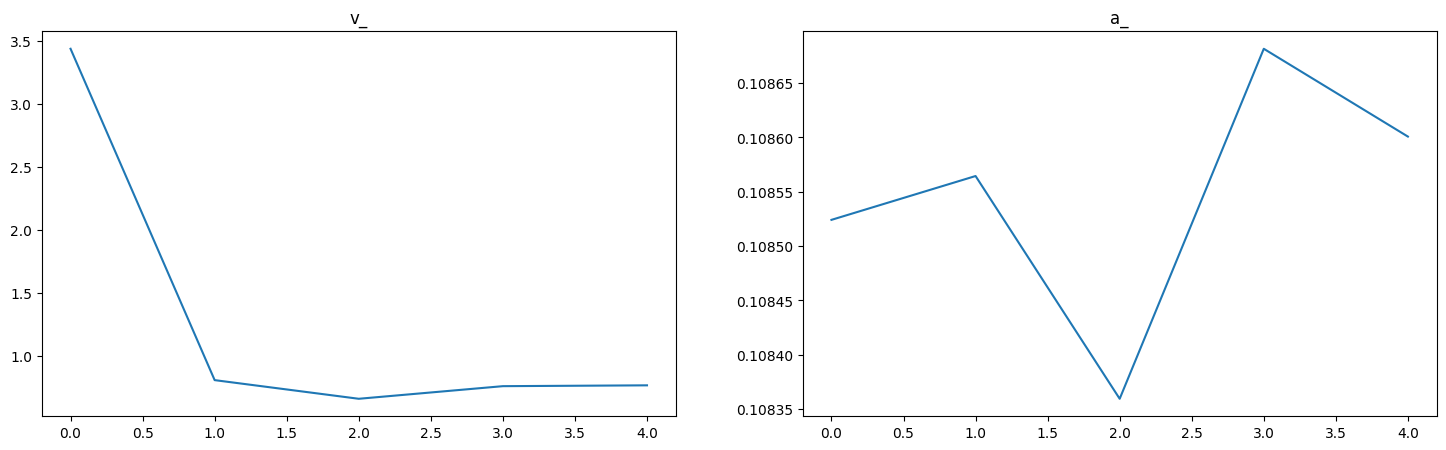

In [29]:
v_true = []
a_true = []
x_train33 = x_train3.unsqueeze(1)
r = np.linspace(0, T_4, N_4)

sol3 = LE.solve_Riccati_ODE(r)

for i in range(len(t_train3)):
    v_ass = LE.value_function(t_train3[i], x_train33)
    a_ss = LE.Markov_control_function(t_train3[i].squeeze(),x_train33)
    v_true.append(v_ass)
    a_true.append(a_ss)

v_pre=[]
a_pre=[] 

for i in range(len(v)-2):
  v_pre.append(float(torch.mean(abs(v[i+2]-v_true[i+2]))))
  a_pre.append(float(torch.mean(abs(a[-1].unsqueeze(1)-a_true[i+1]))))

fig, ax = plt.subplots(1,2,figsize=(18,5))
ax[0].plot(range(len(v)-2),v_pre)
ax[0].set_title('v_')
ax[1].plot(range(len(a)-1),a_pre)
ax[1].set_title('a_')

## Exercise 4 analysis

### Class ex4()
This code defines a class called ex4. The __init__ method takes in four arguments: net_v, net_a, t_train, and x_train. These arguments are used to initialize the net_v, net_a, alpha1, t_train, and x_train attributes of the ex4 instance.

The sample method takes in a size argument and returns a tensor x that is the concatenation of t_train and x_train along the second dimension, as well as a tensor x_initial that is the concatenation of a tensor of zeros with a randomly generated 2-dimensional tensor.

The loss_func method takes in a size argument and uses the sample method to generate x and x_initial tensors. It then calculates the gradient of net_v with respect to x, and uses this gradient to calculate the second-order derivatives of net_v with respect to x. It also defines several tensors that are used to calculate the loss function, including alpha1, x_f, C1, H1, D1, M1, R1, x0, x_i_1, and x_i_2. And the loss function is defined as: $$H(θ_act) = Hx^i∂_Xν+Ma∂_xu+x^TCx+a^TDa$$


Finally, the method calculates the error between the function f (which is defined using the tensors mentioned above) and its expected value, which is equal to 0. The output of the method is the mean of the squared differences between f and 0.

### Policy iteration implementation

The while loop condition checks if the absolute difference between the mean of the last two computed solutions for the heat equation is greater than 0.99. This suggests that the loop will continue until the computed solution stabilizes.


The equation is then solved using the current value of 'a' and the deep learning model 'net3' (which is a neural network trained to solve the third equation). The resulting solution is stored in a new deep learning model 'net_v' using the 'Train' function with 100 epochs, learning rate of 0.001, and batch size 'size3'. The computed solution at each time step is stored in a list 'v'.

The difference between the last two computed solutions is then printed to track convergence.

Next, a new deep learning model 'net_a' is trained using the computed solutions stored in 'v' and the deep learning model 'net4'. The training is done using the 'ex4' function in order to update the markov value, . The trained model is then used to predict the acceleration at each time step, and the output is stored in 'o_a'.

Finally, 'o_a' is stored in list 'a', and the loop continues until the computed solution converges.

### Output 

The value function is decreasing but does not seems to be converged and the alpha is diverging absoultely. I think the reason might be there exsits logic error while we were implementating the code.








